In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

In [3]:
# Load birds.csv
birds_df = pd.read_csv('birds.csv')

In [4]:
# Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(birds_df['labels'].unique())}
birds_df['label_idx'] = birds_df['labels'].map(label_mapping)

In [5]:
# Check class distribution
train_counts = birds_df[birds_df['dataset'] == 'train']['labels'].value_counts()
test_counts = birds_df[birds_df['dataset'] == 'test']['labels'].value_counts()
valid_counts = birds_df[birds_df['dataset'] == 'valid']['labels'].value_counts()

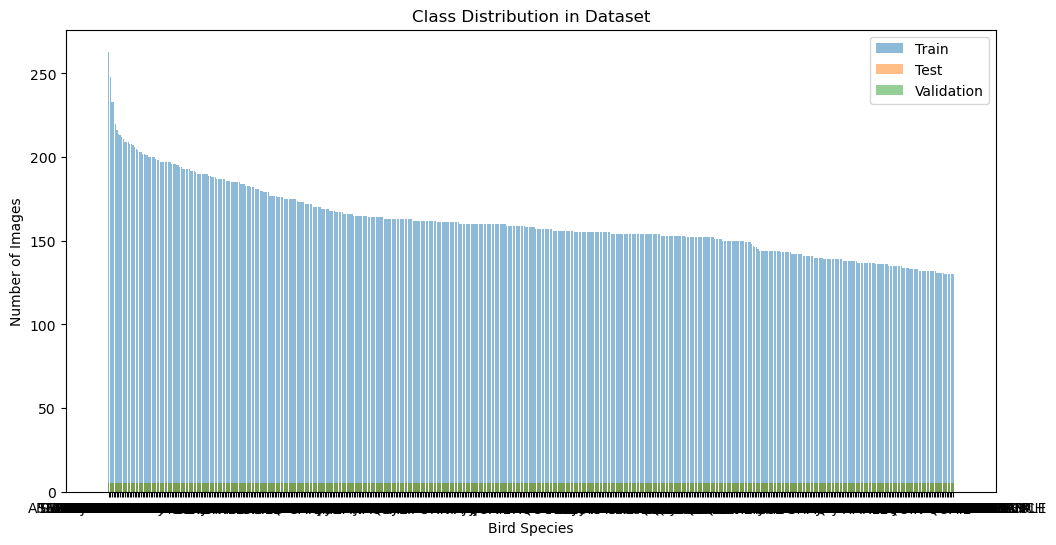

In [6]:
# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(train_counts.index, train_counts.values, alpha=0.5, label='Train')
plt.bar(test_counts.index, test_counts.values, alpha=0.5, label='Test')
plt.bar(valid_counts.index, valid_counts.values, alpha=0.5, label='Validation')
plt.xlabel('Bird Species')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.legend()
plt.show()

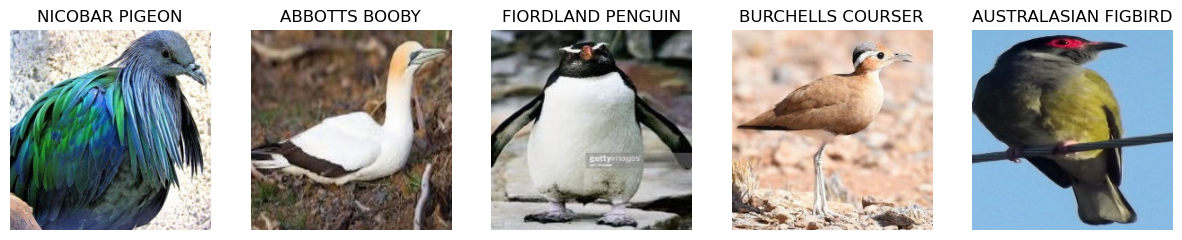

In [7]:
# Display sample images
sample_images = birds_df[birds_df['dataset'] == 'train'].sample(n=5)

plt.figure(figsize=(15, 6))
for i, (index, bird) in enumerate(sample_images.iterrows()):
    plt.subplot(1, 5, i + 1)
    img = Image.open(bird['filepaths'])
    plt.imshow(img)
    plt.title(bird['labels'])
    plt.axis('off')
plt.show()

In [8]:
class BirdDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepaths']
        image = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx]['label_idx']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# Define transforms
img_height = 150
img_width = 150

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
# Create datasets and dataloaders
train_dataset = BirdDataset(birds_df[birds_df['dataset'] == 'train'], transform=train_transforms)
val_dataset = BirdDataset(birds_df[birds_df['dataset'] == 'valid'], transform=val_transforms)
test_dataset = BirdDataset(birds_df[birds_df['dataset'] == 'test'], transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Define the model
class BirdClassifier(nn.Module):
    def __init__(self, filters, units, dropout_rate):
        super(BirdClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(filters, filters, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(filters * 18 * 18, units)  
        self.fc2 = nn.Linear(units, 525)  # Assuming 525 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = x.view(-1, self.num_flat_features(x))  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
# Function to build model
def build_model(filters, units, dropout_rate, learning_rate):
    model = BirdClassifier(filters, units, dropout_rate)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

In [13]:
# Grid search for hyperparameter tuning
def grid_search(train_loader, val_loader):
    filters = [64, 128]
    units = [512, 1024]
    dropout_rates = [0, 0.3]
    learning_rates = [1e-3, 1e-4]
    
    best_val_accuracy = 0
    best_params = {}
    
    for filter_val in filters:
        for unit in units:
            for dropout_rate in dropout_rates:
                for learning_rate in learning_rates:
                    print(f"Testing model with filters={filter_val}, units={unit}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
                    model, criterion, optimizer = build_model(filter_val, unit, dropout_rate, learning_rate)
                    
                    # Train the model
                    train_losses = []
                    val_losses = []
                    train_accuracies = []
                    val_accuracies = []
                    
                    for epoch in range(5):  # Use fewer epochs for faster tuning
                        model.train()
                        running_loss = 0.0
                        correct = 0
                        total = 0
                        
                        for inputs, labels in train_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            optimizer.zero_grad()
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()
                            
                            running_loss += loss.item()
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()
                        
                        avg_train_loss = running_loss / len(train_loader)
                        train_accuracy = correct / total
                        train_losses.append(avg_train_loss)
                        train_accuracies.append(train_accuracy)
                        
                        # Validate the model
                        model.eval()
                        running_val_loss = 0.0
                        correct = 0
                        total = 0
                        
                        with torch.no_grad():
                            for inputs, labels in val_loader:
                                inputs, labels = inputs.to(device), labels.to(device)
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                                
                                running_val_loss += loss.item()
                                _, predicted = torch.max(outputs.data, 1)
                                total += labels.size(0)
                                correct += (predicted == labels).sum().item()
                        
                        avg_val_loss = running_val_loss / len(val_loader)
                        val_accuracy = correct / total
                        val_losses.append(avg_val_loss)
                        val_accuracies.append(val_accuracy)
                        
                        print(f'Epoch [{epoch+1}/5] - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
                    
                    # Evaluate the model
                    model.eval()
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for inputs, labels in val_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()
                    
                    val_accuracy = correct / total
                    print(f'Validation accuracy: {val_accuracy:.4f}')
                    
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_params = {
                            'filters': filter_val,
                            'units': unit,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate
                        }
    
    print(f"Best validation accuracy: {best_val_accuracy}")
    print(f"Best parameters: {best_params}")
    return best_params

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Run grid search to find best hyperparameters
best_params = grid_search(train_loader, val_loader)

Testing model with filters=64, units=512, dropout_rate=0, learning_rate=0.001
Epoch [1/5] - Train Loss: 6.2620, Train Accuracy: 0.0028, Val Loss: 6.2654, Val Accuracy: 0.0019
Epoch [2/5] - Train Loss: 6.2587, Train Accuracy: 0.0030, Val Loss: 6.2682, Val Accuracy: 0.0019
Epoch [3/5] - Train Loss: 6.2580, Train Accuracy: 0.0030, Val Loss: 6.2679, Val Accuracy: 0.0019
Epoch [4/5] - Train Loss: 6.2578, Train Accuracy: 0.0031, Val Loss: 6.2689, Val Accuracy: 0.0019
Epoch [5/5] - Train Loss: 6.2584, Train Accuracy: 0.0031, Val Loss: 6.2684, Val Accuracy: 0.0019
Validation accuracy: 0.0019
Testing model with filters=64, units=512, dropout_rate=0, learning_rate=0.0001
Epoch [1/5] - Train Loss: 5.3998, Train Accuracy: 0.0450, Val Loss: 4.3640, Val Accuracy: 0.1470
Epoch [2/5] - Train Loss: 4.5794, Train Accuracy: 0.1238, Val Loss: 3.6202, Val Accuracy: 0.2480
Epoch [3/5] - Train Loss: 4.1870, Train Accuracy: 0.1796, Val Loss: 3.1189, Val Accuracy: 0.3379
Epoch [4/5] - Train Loss: 3.8967, Train

In [16]:
# Build and train the final model with the best hyperparameters
best_model, criterion, optimizer = build_model(best_params['filters'], best_params['units'], best_params['dropout_rate'], best_params['learning_rate'])

In [17]:
# Train the final model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_model.train()
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validate the model
    best_model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/20] - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20] - Train Loss: 5.1489, Train Accuracy: 0.0685, Val Loss: 3.8599, Val Accuracy: 0.2137
Epoch [2/20] - Train Loss: 4.1775, Train Accuracy: 0.1768, Val Loss: 2.9318, Val Accuracy: 0.3585
Epoch [3/20] - Train Loss: 3.7012, Train Accuracy: 0.2501, Val Loss: 2.5584, Val Accuracy: 0.4286
Epoch [4/20] - Train Loss: 3.3957, Train Accuracy: 0.3014, Val Loss: 2.2335, Val Accuracy: 0.4846
Epoch [5/20] - Train Loss: 3.1887, Train Accuracy: 0.3338, Val Loss: 2.0256, Val Accuracy: 0.5360
Epoch [6/20] - Train Loss: 2.9912, Train Accuracy: 0.3709, Val Loss: 1.8917, Val Accuracy: 0.5650
Epoch [7/20] - Train Loss: 2.8674, Train Accuracy: 0.3915, Val Loss: 1.8018, Val Accuracy: 0.5836
Epoch [8/20] - Train Loss: 2.7394, Train Accuracy: 0.4128, Val Loss: 1.6859, Val Accuracy: 0.6042
Epoch [9/20] - Train Loss: 2.6432, Train Accuracy: 0.4323, Val Loss: 1.5922, Val Accuracy: 0.6190
Epoch [10/20] - Train Loss: 2.5503, Train Accuracy: 0.4504, Val Loss: 1.5768, Val Accuracy: 0.6347
Epoch [11/20] - Tra

In [18]:
# Evaluate the model on the test set
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.7410


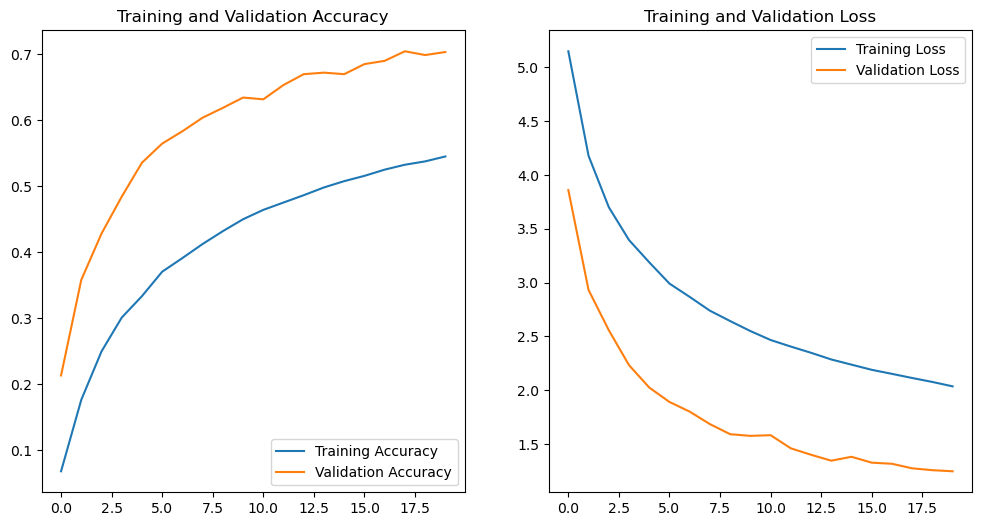

In [19]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()